In [ ]:
import pandas as pd
import numpy as np
import datetime
import holidays

import networkx as nx
from matplotlib import pyplot as plt

In [ ]:
def create_trip_DF(path):
  df = pd.read_csv(path)
  df.drop(['extra', 'RatecodeID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'passenger_count', 'store_and_fwd_flag', 'tolls_amount', 'VendorID', 'tip_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'mta_tax'], axis=1, inplace=True)
  df.rename(columns={'tpep_pickup_datetime':'pickup_datetime', 'tpep_dropoff_datetime':'dropoff_datetime', 'PULocationID': 'pickup_location_ID', 'DOLocationID':'dropoff_location_ID'}, inplace=True)
  df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')
  df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')
  df.dropna()
  return df

In [ ]:
trip_DF = create_trip_DF('/content/yellow_tripdata_2019-01.csv')

In [ ]:
time_of_day_bins = ['PU_time_2AM-5:59AM', 'PU_time_6AM-9:59AM',
               'PU_time_10AM-1:59PM', 'PU_time_2PM-5:59PM',
               'PU_time_6PM-9:59PM', 'PU_time_10PM-1:59AM']

def get_time_of_day_bin(timestamp, time_of_day_bins):
  if 2 <= timestamp.hour and timestamp.hour < 6:
    return time_of_day_bins[0]
  elif 6 <= timestamp.hour and timestamp.hour < 10:
    return time_of_day_bins[1]
  elif 10 <= timestamp.hour and timestamp.hour < 14:
    return time_of_day_bins[2]
  elif 14 <= timestamp.hour and timestamp.hour < 18:
    return time_of_day_bins[3]
  elif 18 <= timestamp.hour and timestamp.hour < 22:
    return time_of_day_bins[4]
  else:
    return time_of_day_bins[5]

In [ ]:
def append_and_fill_time_of_day_bins(df, time_of_day_bins):
  for time_bin in time_of_day_bins:
    print(time_bin)
    df[time_bin] = df['pickup_datetime'].map(lambda timestamp: 1 if get_time_of_day_bin(timestamp, time_of_day_bins) == time_bin else 0)

In [ ]:
append_and_fill_time_of_day_bins(trip_DF, time_of_day_bins)

PU_time_2AM-5:59AM
PU_time_6AM-9:59AM
PU_time_10AM-1:59PM
PU_time_2PM-5:59PM
PU_time_6PM-9:59PM
PU_time_10PM-1:59AM


In [ ]:
weekend_days = [5, 6]
us_holidays = holidays.US()
def is_weekend_or_holiday(date):
  date_day = date.day
  stringified_date = str(date)
  if date_day in weekend_days:
    return True
  elif stringified_date in us_holidays:
    return True
  else:
    return False

In [ ]:
trip_DF['pickup_date'] = trip_DF['pickup_datetime'].map(lambda timestamp: timestamp.date())

In [ ]:
def create_avg_fare_df(df):
  fare_prediction_df = df.groupby(["pickup_location_ID", "dropoff_location_ID", "pickup_date"] + time_of_day_bins, as_index=False).agg(avg_fare=('fare_amount', 'mean'))
  return fare_prediction_df

In [ ]:
trip_avg_fare_DF = create_avg_fare_df(trip_DF)

In [ ]:
# if trips occur on weekend or US holiday
trip_avg_fare_DF['weekend/holiday'] = trip_avg_fare_DF['pickup_date'].map(lambda date: 1 if is_weekend_or_holiday(date) else 0)

In [ ]:
trip_avg_fare_DF.head(10)

,pickup_location_ID,dropoff_location_ID,pickup_date,PU_time_2AM-5:59AM,PU_time_6AM-9:59AM,PU_time_10AM-1:59PM,PU_time_2PM-5:59PM,PU_time_6PM-9:59PM,PU_time_10PM-1:59AM,avg_fare,weekend/holiday
0,1,1,2019-01-01,0,0,0,0,0,1,73.000000,1
1,1,1,2019-01-01,0,0,0,0,1,0,46.000000,1
2,1,1,2019-01-01,0,0,0,1,0,0,72.500000,1
3,1,1,2019-01-01,0,0,1,0,0,0,67.777778,1
4,1,1,2019-01-01,0,1,0,0,0,0,106.666667,1
5,1,1,2019-01-01,1,0,0,0,0,0,52.500000,1
6,1,1,2019-01-02,0,0,0,0,1,0,75.500000,0
7,1,1,2019-01-02,0,0,0,1,0,0,52.166667,0
8,1,1,2019-01-02,0,0,1,0,0,0,68.142857,0
9,1,1,2019-01-02,0,1,0,0,0,0,75.000000,0


In [ ]:
len(trip_avg_fare_DF.index)

877718

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f197c77aef0>]],
      dtype=object)

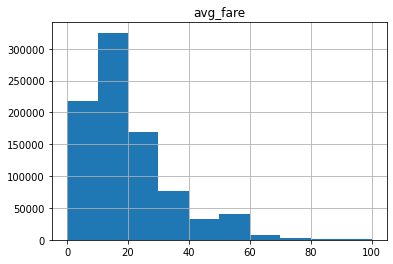

In [158]:
trip_avg_fare_DF.hist(column="avg_fare", bins=10, range=(0, 100))